#**IMAGE CAPTIONING USING RESNET50 AND LSTM WITH TENSORFLOW**




**Project APM 598**




**Name: <br/>
Amit Yashwantrao (1218028123)<br/>
Nikita Joshi(1217655348)<br/>
Soubhagya Nayak (1217084193)**

###**INTRODUCTION**

***The process of generating textual descriptions of an image based on the actions and objects in the image is called Image Captioning. Image captioning involves extracting features and details from the image using an image-based model and then translating those features and details to natural sentences using the language-based model. This is a rapidly expanding research field of computer vision, implying that the machine is capable of more than just classification or detection. Captioning images and videos are one of the most popular applications in society which demands intelligent computing systems.***

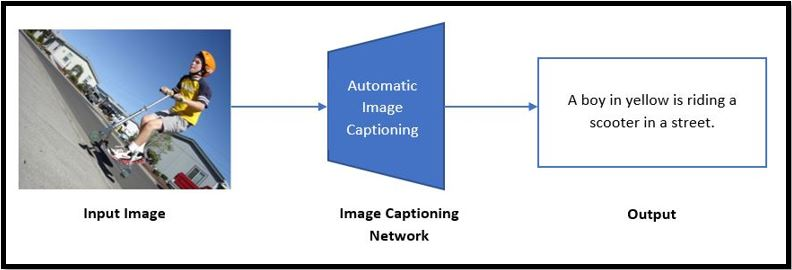

                              Fig 1: Image Captioning

***The Dataset is stored in the google drive and the drive is mounted to extract the data.***

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Importing all the required libraries***

In [11]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from keras.preprocessing import image, sequence
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image, sequence


***Directories to extract the particular folders and data***

In [12]:
images_dir = os.listdir("/content/drive/My Drive/data")

images_path = '/content/drive/My Drive/data/images/'
captions_path = '/content/drive/My Drive/text/Flickr8k.token.txt'
train_path = '/content/drive/My Drive/text/Flickr_8k.trainImages.txt'
val_path = '/content/drive/My Drive/text/Flickr_8k.devImages.txt'
test_path = '/content/drive/My Drive/text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

***The captions are loaded as values and images are loaded as keys to those values. A dictionary of these keys and values is loaded. We then take an image and display it with the associated caption to make sure that mapping of these keys and values has been done properly. Correct mapping is a prerequisite as it is like a preparation of data before it trained. The image has 5 different captions so as to help the model(when is training)to know which object in the image holds what keywords. Proper keyword and value matching is a trick to perfect image captioning.***

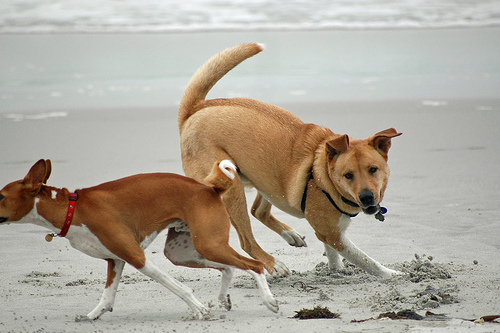

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [13]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

# displaying an image and captions given to it
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])
        

***Further we create training and testing files for validations having a header as “image id” and “captions”. Captions require a “start” and “end” prompt as per rules of language generators. Hence these tokens are inserted at the beginning and end of the captions thus populating the image id and caption files.***

In [14]:
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

###***A ResNet (Residual Network)Model with 50 layers is loaded.***

The top layer of ResNet is removed as in this multimodel application we wish to feed in both images and captions. Hence a language model LSTM will also be required that shall be seen in further steps. Encoded images + tokenized captions together make the LSTM model that predicts captions. A warning has been issued due to version compatibility. This version of the model maybe depreciated in some platforms in the future.

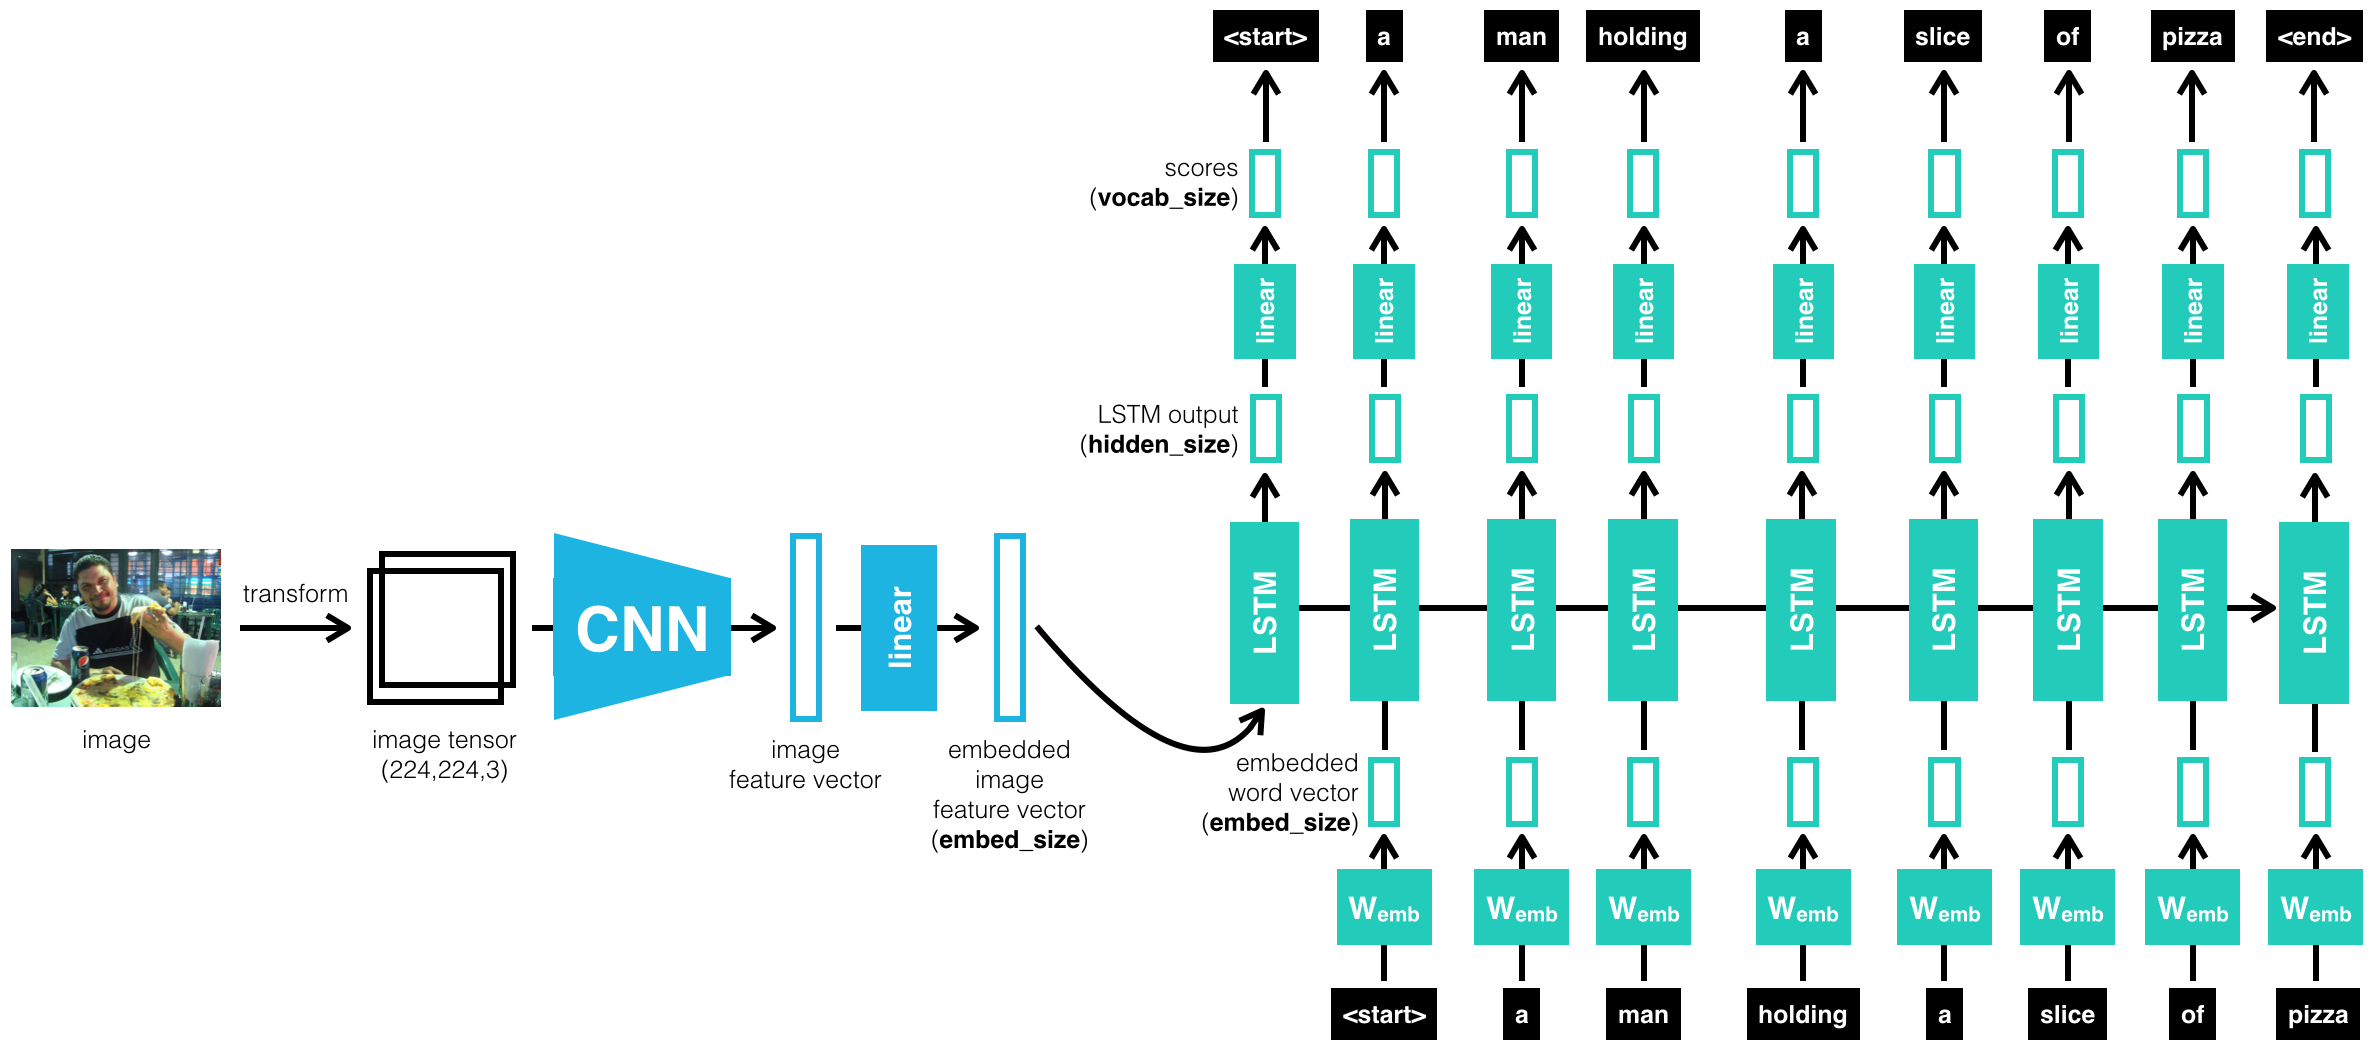

In [15]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

##**TRAINING**

###Using the function of train_data{} data is trained in batches of 3000,2000 and 1000. This step requires time as huge batches of data are trained one at a time.

In [17]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [18]:
# checkpoint for training data that will be used
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

***“Pickle files” are files that are stored and contain prepared data. In this case the prepared files are those that contain these serials training image data.***

In [19]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [20]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


***A language generation model requires a header(/start) prompt and (/end) prompt. To make sure the new mapping is done correctly.***

In [21]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [22]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

***Then we split every caption that is stored as a sentence into individual words.***

In [23]:
words = [i.split() for i in sentences]

# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


***Vectorization of the data is indexed for every value. That is any word from the dataset is printed it will be allotted a particular index and vice versa. Word to indices and indices to words help to find proper word match.***

In [24]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

vocab_size = len(word_2_indices.keys())

In [25]:
# finding maximum length to check for biggest caption in the dataset
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


***Sequence padding helps in padding the sentences that have a misaligned shape before fed into the model. Padding basically makes everything of the same length and brings uniformity. Hence the next part of the code consists of sequential padding. One-HOT encoding is done as well at this step. Captions are converted into a sequence that is fed to the model. They can be printed. Sequences are shown and created in a time series format. This time series are basically the captions that are further fed to the LSTM model. . As data can be first unknown to the model ,“UNK” that is indexed as “0” but as it uses the trained dataset it starts unravelling every word that’s captioning the chosen picture.***

In [26]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

# checkpoint for padded sequence, subsequent word size
#print(padded_sequences.shape)
#print(subsequent_words.shape)

'''padded sequence can be checked to correct the sentences which are misaligned
   in shape before fed to the model'''
#print(padded_sequences[0])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


'padded sequence can be checked to correct the sentences which are misaligned\n   in shape before fed to the model'

In [27]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [28]:
# number of images have been limited to 2000 as per computation capability
num_of_images = 2000

captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

#print(captions.shape)
#print(next_words.shape)

In [29]:
with open('/content/drive/My Drive/train_encoded_images.p', 'rb') as f:
  
    encoded_images = pickle.load(f, encoding="bytes")

In [30]:
# to create an array of newly acquired images
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
         print(ix, encoded_images[ds[ix, 0].encode()])
         imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)


Streaming output truncated to the last 5000 lines.
10180 [0.13319212 4.2034254  0.03997023 ... 0.26648244 0.44775102 2.803774  ]
10181 [0.13319212 4.2034254  0.03997023 ... 0.26648244 0.44775102 2.803774  ]
10182 [0.13319212 4.2034254  0.03997023 ... 0.26648244 0.44775102 2.803774  ]
10183 [0.13319212 4.2034254  0.03997023 ... 0.26648244 0.44775102 2.803774  ]
10184 [0.13319212 4.2034254  0.03997023 ... 0.26648244 0.44775102 2.803774  ]
10185 [0.58273983 0.65645516 0.         ... 0.04741362 0.1643673  0.23287126]
10186 [0.58273983 0.65645516 0.         ... 0.04741362 0.1643673  0.23287126]
10187 [0.58273983 0.65645516 0.         ... 0.04741362 0.1643673  0.23287126]
10188 [0.58273983 0.65645516 0.         ... 0.04741362 0.1643673  0.23287126]
10189 [0.58273983 0.65645516 0.         ... 0.04741362 0.1643673  0.23287126]
10190 [0.08391451 1.4268789  0.         ... 0.         0.         0.1828078 ]
10191 [0.08391451 1.4268789  0.         ... 0.         0.         0.1828078 ]
10192 [0.0839

In [31]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

# checkpoint
#print(images.shape)

In [32]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)


*** Note: ".npy" files are the numerical values of the captions and following lists of captions that come in the previously made dictionary, image lists and image names, which are loaded and we begin building the layers of our model. ***

In [33]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

images = np.load("images.npy")
imag = np.load("image_names.npy")

####**Layer 1: Firstly, as the top layer was removed from ResNet , the 1st layer is added which is the initialization layer. This layer is attached in front of the ResNet model. It consists of 3 sequences:**



**Sequence 1**: This is the 1st layer which mainly consists of the images and image values/names.

In [34]:
embedding_size = 128
max_len = 40


image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


**Sequence 2**: This is the LSTM language model that contains captions and caption values from the dictionary, both the past and present. It is also called LSTM_model.

In [35]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


**Sequence 3:** As this project involves multi-modal output and training the first 2 sequences are concatenated in this sequence. It is also called the concate_model.

In [36]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

#model.load_weights("model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
______________________________________________________________________________________________

##**Finally, this layer is added at the top of the previous ResNet50 which has 50 layers in total. “hist” command is used to use the previous values that are loaded and the new ones and begin training. The model is stored as well.**

###There are 200 epochs and 512 is the batch size as we felt that those many epochs gave maximum accuracy later during testing. The model is saved in the folder.

In [37]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=225)

Epoch 1/225
50/50 [==============================] - 10s 105ms/step - loss: 6.2283 - accuracy: 0.0689
Epoch 2/225
50/50 [==============================] - 5s 106ms/step - loss: 5.3027 - accuracy: 0.0779
Epoch 3/225
50/50 [==============================] - 5s 106ms/step - loss: 5.1921 - accuracy: 0.0752
Epoch 4/225
50/50 [==============================] - 5s 107ms/step - loss: 5.1419 - accuracy: 0.0733
Epoch 5/225
50/50 [==============================] - 5s 107ms/step - loss: 5.0646 - accuracy: 0.0793
Epoch 6/225
50/50 [==============================] - 5s 106ms/step - loss: 4.7878 - accuracy: 0.1382
Epoch 7/225
50/50 [==============================] - 5s 105ms/step - loss: 4.5800 - accuracy: 0.1635
Epoch 8/225
50/50 [==============================] - 5s 105ms/step - loss: 4.3815 - accuracy: 0.2007
Epoch 9/225
50/50 [==============================] - 5s 104ms/step - loss: 4.2268 - accuracy: 0.2292
Epoch 10/225
50/50 [==============================] - 5s 103ms/step - loss: 4.0465 - accur

In [38]:
# saving the model
model.save_weights("model_weights.h5")

##**TESTING**

###To test this model first we again called the helper functions for prepocessing data. We decide to test this model on a new set of images. Ones that are not in the 2000 images that were taken during testing and hence preprocessing ,encoding and declaring the new ResNet model again is required.

In [39]:

def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [40]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [41]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [42]:
img = "/content/drive/My Drive/data/images/1453366750_6e8cf601bf.jpg"

test_img = get_encoding(resnet, img)

**We then define a function for prediction of captions from given list that it has been trained on.**

In [43]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

caption_final = predict_captions(test_img)

##**Testing the model over random images from the dataset and even outside of the dataset**

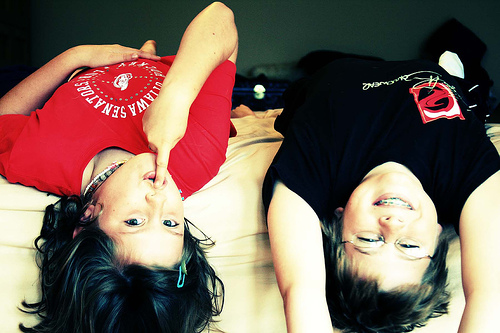

Two children are shown upside down to their bed .


In [44]:
z = Image(filename=img)
display(z)

print(caption_final)

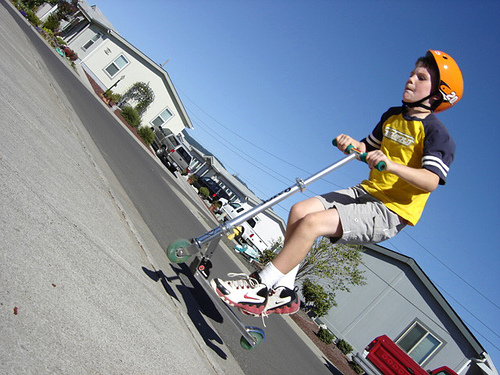

A boy on a scooter is on a turn .


In [45]:

img = "/content/drive/My Drive/data/images/47870024_73a4481f7d.jpg"

test_img = get_encoding(resnet, img)
caption_final = predict_captions(test_img)
z = Image(filename=img)
display(z)

print(caption_final)

##**EVALUATION**

###**ACCURACY**

dict_keys(['loss', 'accuracy'])


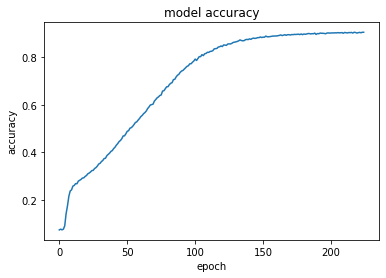

In [46]:
print(hist.history.keys())
plt.plot(hist.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

###**LOSS**

dict_keys(['loss', 'accuracy'])


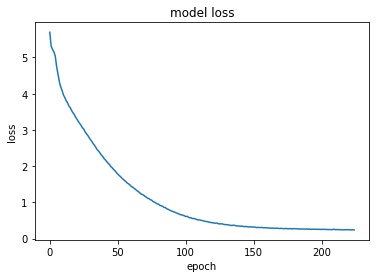

In [47]:
print(hist.history.keys())
plt.plot(hist.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()